In [35]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from scipy import stats

**Summary of the results :**
- Four suggested formats for sending exam results: current one, sending all grades at once, updating grades on ISA only once a day, updating grades on EPFL Campus only once a day while leaving ISA untouched.
- Preferred format for sending grades is: for CMS/BA1 students, all grades at once, then for students in later years: updating grades on ISA only once a day.
- Updating grades on ISA only once a day is ok for everyone, if we cannot separate between first year and later years.
- In the meantime, updating grades on EPFL campus only once a day while leaving ISA untouched is ok for all years.

In [36]:
def semester_numerical(semester_string):
    if semester_string.startswith("BA"):
        return int(semester_string[-1])
    elif semester_string.startswith("MA"):
        return int(semester_string[-1]) + 6
    elif semester_string == "CMS":
        return 0
    elif semester_string == "PDM":
        return 11
    else:
        return np.nan

def ternarize(value):
    if value == 3:
        return 0
    elif value < 3:
        return -1
    else:
        return 1

In [37]:
df = pd.read_csv("grades_results.csv")
columns = ["semester", "section", "current_anxiety", "current", "isa_once_a_day", "app_once_a_day", "all_grades"]
df = df[columns]
df["semester_numerical"] = df["semester"].map(semester_numerical)
df = df.dropna()
df.head()

,semester,section,current_anxiety,current,isa_once_a_day,app_once_a_day,all_grades,semester_numerical
0,BA1,IN,4,4,2,2,4,1.0
1,MA3,PH,5,1,5,2,4,9.0
2,BA3,MT,5,1,2,4,5,3.0
3,MA1,MT,3,4,4,5,2,7.0
4,BA1,MT,5,2,5,3,2,1.0


The columns mean the following:
- ``semester``: semester of study when filling out the poll
- ``semester_numerical``: same as ``semester`` but counting from 0 (CMS) to 11 (PDM)
- ``section``: obvious
- ``current_anxiety``: answer to "Is the current format for sending results a source of stress, anxiety, or any other feelings for you?", values range from 1: "not at all" to 5: "yes, a lot"
- ``current``: answer to "Do these formats for sending exam results suit you?" for the current format, values range from 1: "not at all" to 5: "completely"
- ``isa_once_per_day``: answer to "Do these formats for sending exam results suit you?" for the format of updating the grades on ISA only once a day at a fixed time (and thus grades cannot appear on Pocket Campus at random times), values range from 1: "not at all" to 5: "completely"
- ``app_once_per_day``: answer to "Do these formats for sending exam results suit you?" for the format of updating the grades on PocketCampus only once a day at a fixe time (but grades can still appear on ISA at random times), values range from 1: "not at all" to 5: "completely"
- ``all_grades``: answer to "Do these formats for sending exam results suit you?" for the format of sending all grades at once, values range from 1: "not at all" to 5: "completely"

We set the significant threshold to be 5%.

First, some basic plots:

mean: 3.2857142857142856


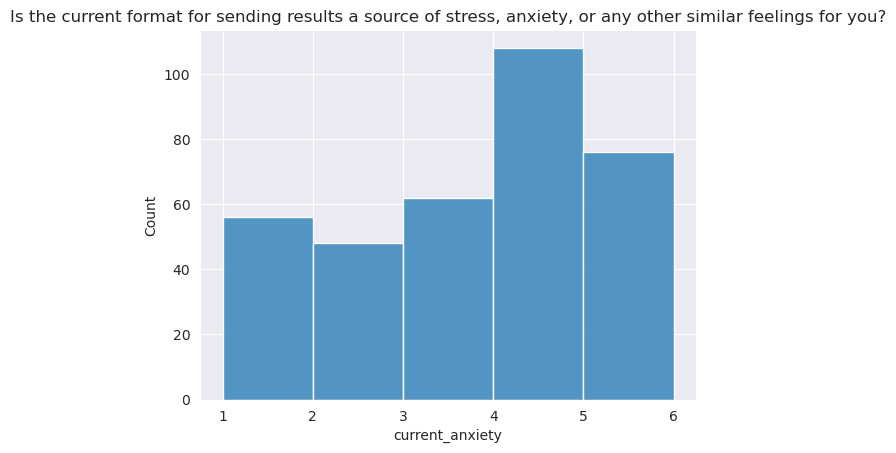

In [38]:
fig, axs = plt.subplots()
sns.histplot(df["current_anxiety"], bins=[1,2,3,4,5,6]).set_title("Is the current format for sending results a source of stress, anxiety, or any other similar feelings for you?")
print(f"mean: {df['current_anxiety'].mean()}")
fig.savefig("plots/current_stress_anxiety.png")

This plot justifies that the current format for sending exam results is stress inducing. Can we do better?

mean current: 2.8142857142857145
mean isa_once_a_day: 3.5171428571428573
mean app_once_a_day: 3.157142857142857
mean all_grades: 2.78


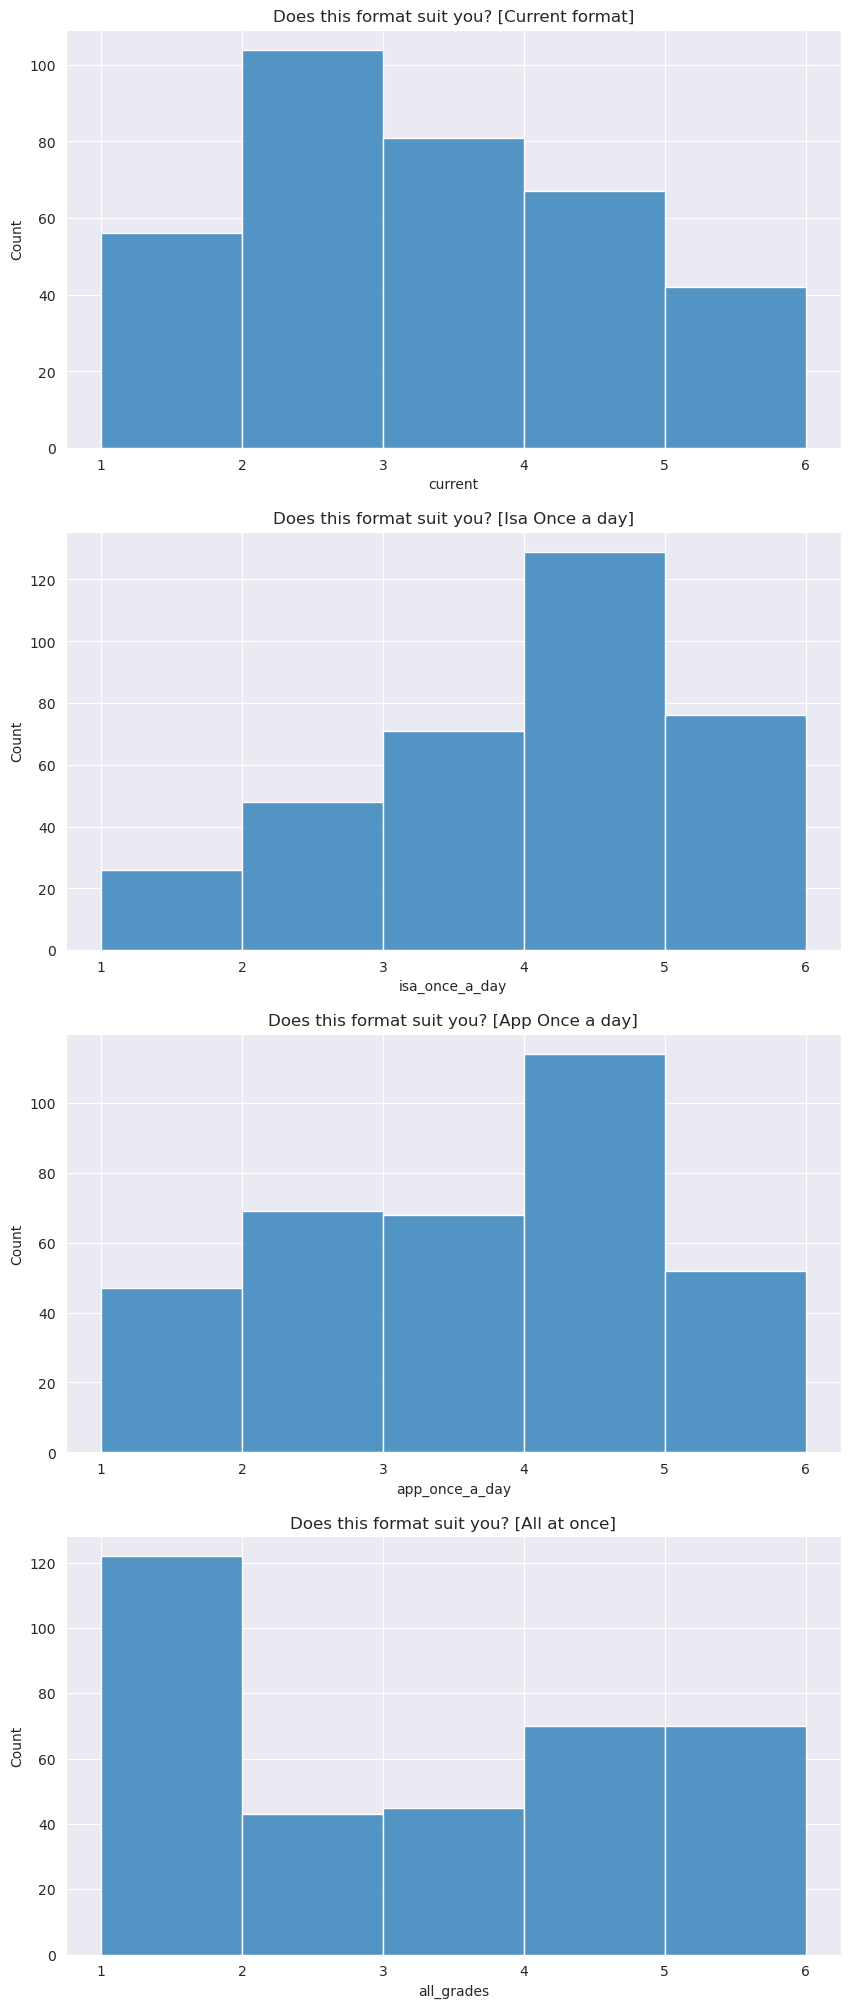

In [39]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10, 25))
axs = axs.flatten()

with open("stats/means_format.txt", "w") as f:
    f.truncate(0)

def histplot_formats(col, title_append, ax):
    sns.histplot(df[col], bins=[1,2,3,4,5,6], ax=axs[ax]).set_title(f"Does this format suit you? [{title_append}]")
    with open("stats/means_format.txt", "a") as f:
        res = f"mean {col}: {df[col].mean()}"
        print(res)
        print(res, file=f)
    
histplot_formats("current", "Current format", 0)
histplot_formats("isa_once_a_day", "Isa Once a day", 1)
histplot_formats("app_once_a_day", "App Once a day", 2)
histplot_formats("all_grades", "All at once", 3)

fig.savefig("plots/all_formats_separated.png")

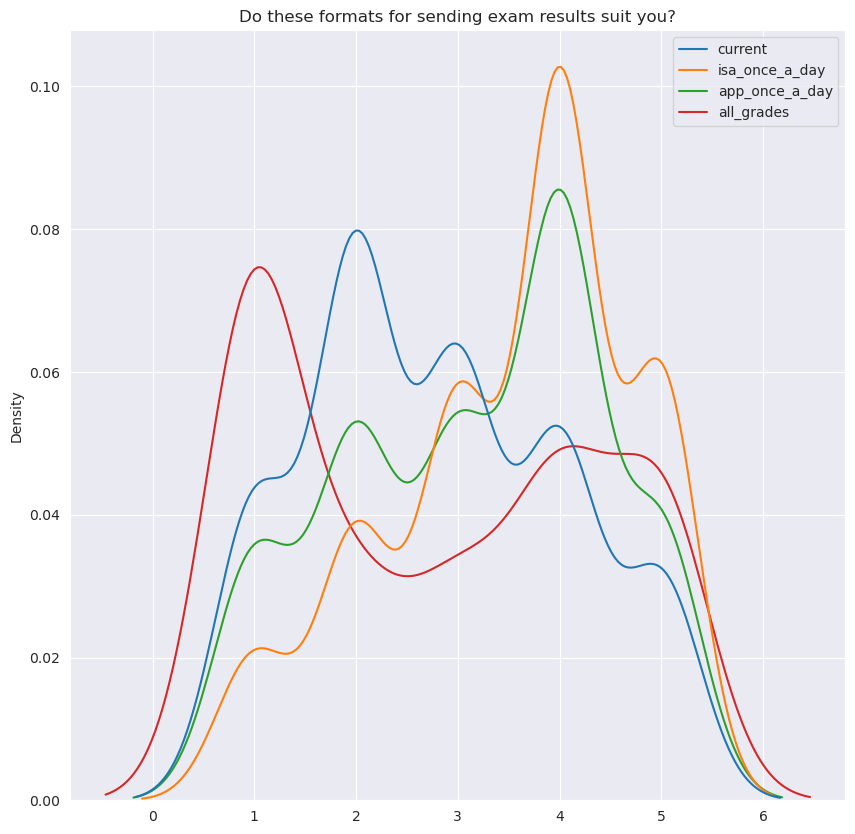

In [40]:
fig, axs = plt.subplots(figsize=(10,10))
sns.kdeplot(df[["current", "isa_once_a_day", "app_once_a_day", "all_grades"]], legend=True).set_title("Do these formats for sending exam results suit you?")
fig.savefig("plots/all_in_one_plot.png")

From these plots it seems like the best format is the so called ``isa_once_a_day``, and ``app_once_a_day`` is a close second. We still need to check however that the current affected population does prefer these 2 options:

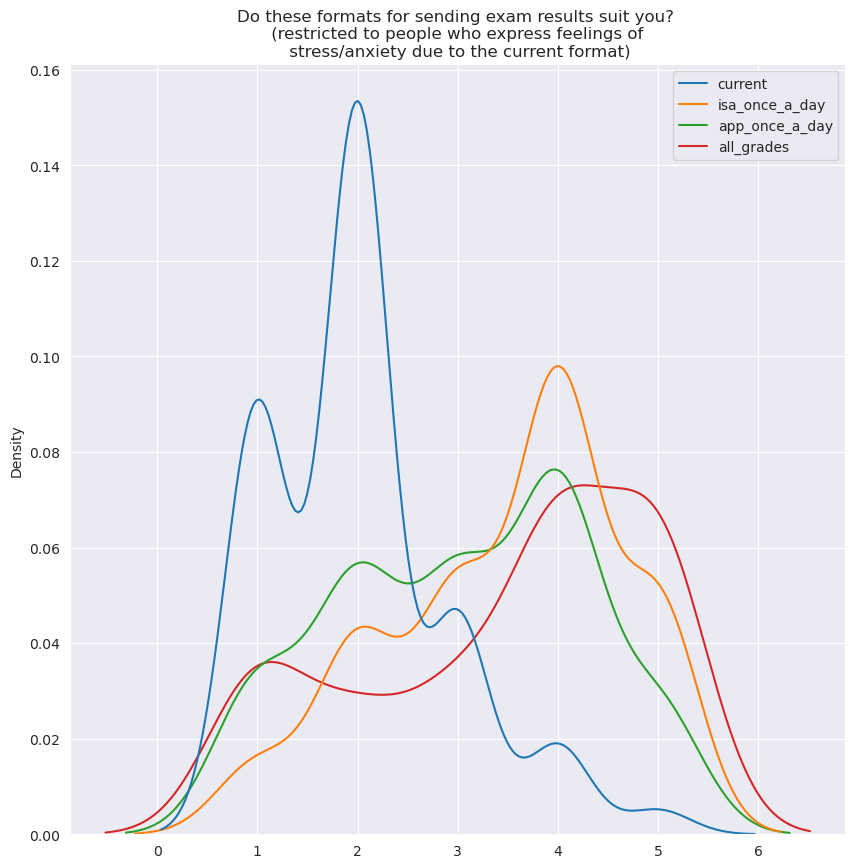

In [41]:
fig, axs = plt.subplots(figsize=(10, 10))
affected_df = df[df["current_anxiety"].map(ternarize) == 1]
sns.kdeplot(affected_df[["current", "isa_once_a_day", "app_once_a_day", "all_grades"]], legend=True).set_title("Do these formats for sending exam results suit you? \n (restricted to people who express feelings of \n stress/anxiety due to the current format)")
fig.savefig("plots/all_in_one_plot_affected.png")

Interestingly, for that class of the population, it's less clear that the two aforementioned options are the best. Nonetheless, all three seem better than the current format.

**Hence, the option to update grades on ISA (or the future PLEXUS platform) only once a day is the option that should be preferred.**
However, changing ISA at that scale is complex, and PLEXUS is only due in quite a long time. Hence we study whether update grades on EPFL campus only one a day (while keeping ISA untouched) is a good alternative - on first glance, from these plots, it at least seems like it.

In [42]:
stats.pearsonr(df["isa_once_a_day"], df["app_once_a_day"])

PearsonRResult(statistic=0.37883350148763406, pvalue=2.1803650460794094e-13)

In [43]:
stats.pearsonr(df["isa_once_a_day"].map(ternarize), df["app_once_a_day"].map(ternarize))

PearsonRResult(statistic=0.38297823999883607, pvalue=1.1346853247705093e-13)

The populations for whom the options ``isa_once_a_day`` and ``app_once_a_day`` are significantly positively correlated. Also:

In [44]:
stats.pearsonr(df["current_anxiety"], df["app_once_a_day"], alternative="less")

PearsonRResult(statistic=-0.12710561393695494, pvalue=0.008677985190246916)

This result can be read as: we accept the hypothesis that the ``app_once_a_day`` alternative generally suits the population affected by the current format.

**Hence we suggest to go forth (for now) with the option of updating grades on EPFL Campus only once a day, while leaving ISA untouched, until ISA (or PLEXUS) can be modified.**

We run a few more sanity checks just to make sure we're not missing important information, for example:
- Do students from a particular year particularly dislike one of the 2 proposed formats?

In [45]:
stats.pearsonr(df["semester_numerical"], df["isa_once_a_day"])

PearsonRResult(statistic=-0.0054704986392941695, pvalue=0.9187738945733411)

In [46]:
stats.pearsonr(df["semester_numerical"], df["app_once_a_day"])

PearsonRResult(statistic=-0.09313707217176682, pvalue=0.08186152626431827)

The correlation is (with significantly high p-value) 0 between the year of study and how much the options of ``isa_once_a_day`` and ``app_once_a_day`` suits them. For proper testing of independence we should run causal tests, which we did not do here in the interest of time.

- Do first year students or CMS students particularly prefer receiving all grades at once?

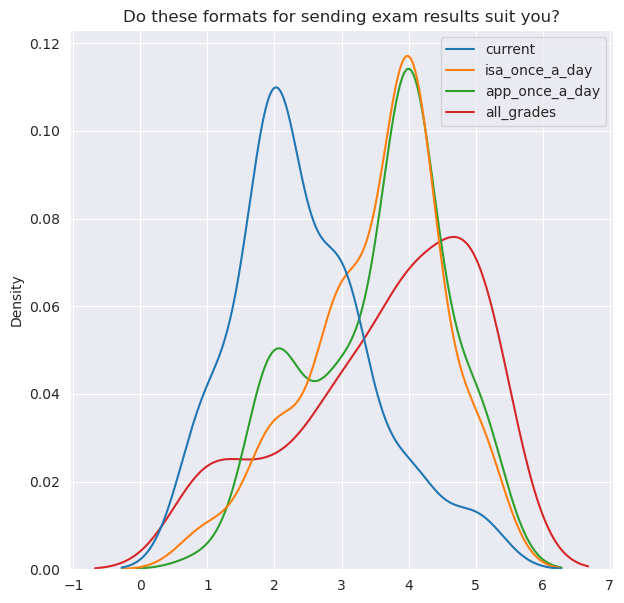

In [47]:
fig, axs = plt.subplots(figsize=(7, 7))
ba1_df = df[df["semester"] == "BA1"]
sns.kdeplot(ba1_df[["current", "isa_once_a_day", "app_once_a_day", "all_grades"]], legend=True).set_title("Do these formats for sending exam results suit you?")
fig.savefig("plots/all_in_one_plot_ba1.png")

It might be slightly true for BA1 students but the two other options are still ok. **We note however that the ``all_grades`` option suits BA1 students better and, if implementable, is worth going towards.**

In [48]:
print(f"Number of BA1 students who responded: {len(df[df['semester'] == 'BA1'])}")
print(f"Number of CMS students who responded: {len(df[df['semester'] == 'CMS'])}")

Number of BA1 students who responded: 79
Number of CMS students who responded: 7


There are not enough CMS students to answer the question - but CMS students receive all grades at once already anyway, and on a reasonable assumption that their opinion would be similar to BA1's, then it's safe to keep things the way they are for CMS students.